In [1]:
import numbers

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch import nn
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import genericpath
from sklearn.metrics import f1_score

np.random.seed(17)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force working on cpu due to memory limitation
#device = torch.device("cpu")


def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result


class YogaPoseDataset(Dataset):

    def __init__(self, root, train, size=(256, 192), transform=None, example_images=None):
        root = root
        subdir = "train" if train else "test"
        self.data_path = os.path.join(root,subdir)
        self.size = size
        self.transform = transform
        # call to init the data
        self._init_data()

    def _init_data(self):
        images = list()

        for _, directory_class in enumerate(os.listdir(self.data_path)):
            class_path = os.path.join(self.data_path, directory_class)
            for file_name in os.listdir(class_path):
                f = cv2.imread(os.path.join(class_path, file_name), cv2.IMREAD_COLOR)

                f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)

                if self.transform is not None:
                    f = self.transform(f)

                data = torch.reshape(torch.FloatTensor(f), (3, self.size[0], self.size[1]))

                # format example  images[x][0] -> (label, input)
                # format example  images[x][1] -> [other information]
                # images[x] -> ((class_id, image_tensor), [filename])
                images.append((int(directory_class), data))


        np.random.shuffle(images,)
        self.images = images

    def __len__(self):
        # returns the number of samples in our dataset
        return len(self.images)

    def getData(self):
        return self.images

    def __getitem__(self, idx):
        """

        Args:
            idx: the index of the sample

        Returns: a tuple (class, input) for the given sample

        """
        return self.images[idx]

    def collate_fn(self, data):
        #print(data)
        Xs = torch.stack([x[1] for x in data])
        y = torch.stack([torch.tensor(x[0]) for x in data])
        return Xs, y

In [2]:
def get_next_logdir():
    from datetime import datetime
    now = datetime.now()
    date_time = now.strftime("%d_%b[%H-%M-%S]")
    multi_val_index = 1
    logs_dir = OUT_DIR + "logs/"
    dir_name = logs_dir + date_time
    while os.path.exists(dir_name):
        multi_val_index += 1
        dir_name = "".join([logs_dir, date_time, "(", str(multi_val_index), ")"])
    return dir_name

def TransPoseVisualizer(exampledataset, out_path, out_index):
    import shutil
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    model.tpr.register_forward_hook(get_activation('tph'))
    examples_dataloader = torch.utils.data.DataLoader(dataset=exampledataset, batch_size=batch_size, shuffle=False,collate_fn=testset.collate_fn)

    for index, (images,_) in enumerate(examples_dataloader):
        with torch.no_grad():
            model.eval()
            images = images.to(device)
            model(images)
            outputs = activation['tph']
            if isinstance(outputs, list):
                output = outputs[-1]
            else:
                output = outputs

            preds, maxvals = get_final_preds(cfg, output.clone().cpu().numpy(), None, None, transform_back=False)

        # from heatmap_coord to original_image_coord
        query_locations = np.array([p * 4 + 0.5 for p in preds[0]])

        inspect_atten_map_by_locations(exampledataset[index][1], model.tpr , query_locations, model_name="transposer", mode='dependency', save_img=True, threshold=0.005, outinfo=(out_path , str(out_index)), device=device)

def get_model_code():
    import inspect, sys
    from IPython.core.magics.code import extract_symbols

    def new_getfile(object, _old_getfile=inspect.getfile):
        if not inspect.isclass(object):
            return _old_getfile(object)

        # Lookup by parent module (as in current inspect)
        if hasattr(object, '__module__'):
            object_ = sys.modules.get(object.__module__)
            if hasattr(object_, '__file__'):
                return object_.__file__

        # If parent module is __main__, lookup by methods (NEW)
        for name, member in inspect.getmembers(object):
            if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
                return inspect.getfile(member)
        else:
            raise TypeError('Source for {!r} not found'.format(object))

    inspect.getfile = new_getfile
    obj = PoseClassifier
    cell_code = "".join(inspect.linecache.getlines(new_getfile(obj)))
    class_code = extract_symbols(cell_code, obj.__name__)[0][0]
    return class_code


def VisualizeFilter(layer, name, out_dir="", before=None):
    import math
    weights = layer.weight.data

    max = torch.max(weights)
    min = torch.min(weights)

    # Figure out how 'wide' each range is
    leftSpan = max - min
    rightSpan = 255 - 0

    # Convert the left range into a 0-1 range (float)
    vals = (weights - min) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    weights = 0 + (vals * rightSpan)
    weights = weights.int()

    # weights = (weights-min)/max
    fig = plt.figure(1)
    title = name
    if before is not None: title = title + (": Before" if before else ": After")
    fig.suptitle(title)

    dimrc = {
        128: (8,16),
        256: (16,16),
        512: (16,32),
        1024: (32,32)
    }
    rows, columns = dimrc[len(weights)]
    # print(weights.size(),weights)
    for idx, image in enumerate(weights):
        fig.add_subplot(rows, columns, idx + 1, frame_on=False, xticks=[], yticks=[], xticklabels=[], yticklabels=[])
        plt.imshow(image.cpu())
    if out_dir != "":
        if not os.path.exists(out_dir): os.makedirs(out_dir)
        plt.savefig(os.path.join(out_dir, name))
    plt.show()

In [3]:
data_aug_parameters = {
    "RC_size": 32, "RC_padding": 2,  # default = none
    "CJ_brightness": 50,  # default = 0
    "CJ_contrast": 0,  # default = 0
    "CJ_saturation": 0,  # default = 0
    "CJ_hue": 0,  # default = 0
    "P_padding": 3, "P_type": "constant",  # default = constant
    "HF_p": 0.5, "VF_p": 0.5, "RR_degrees": 60, "RG_p": 0.2}

data_aug_transform = [transforms.ToPILImage(),#transforms.RandomCrop(data_aug_parameters["RC_size"],
                      # padding=data_aug_parameters["RC_padding"]),
                        transforms.RandomHorizontalFlip(data_aug_parameters["HF_p"]),
                        transforms.RandomVerticalFlip(data_aug_parameters["VF_p"]),
                        transforms.RandomRotation(degrees=data_aug_parameters["RR_degrees"]),
                        transforms.ColorJitter(brightness=data_aug_parameters["CJ_brightness"], contrast=data_aug_parameters["CJ_contrast"], saturation=data_aug_parameters["CJ_saturation"],hue=data_aug_parameters["CJ_hue"]),
                        transforms.RandomGrayscale(data_aug_parameters["RG_p"]),
                      ]
norm_transform = transforms.Compose(data_aug_transform + [transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
DATASET_PATH = './data/split/'
ANNOTATION_PATH = './data/annotations/'
MODEL_NAME = "tpr_a4_256x192"
testset = YogaPoseDataset(DATASET_PATH,train=False, transform=test_transform)
trainset = YogaPoseDataset(DATASET_PATH,train=True, transform=norm_transform)
valset = trainset[(len(trainset)//10)*9:]
trainset = trainset[:(len(trainset)//10)*9]

In [4]:
# get model from torch hub
assert MODEL_NAME in ["tpr_a4_256x192", "tph_a4_256x192"]

transpose_model = torch.hub.load('yangsenius/TransPose:main', MODEL_NAME, pretrained=True)
transpose_model.to(device)

Using cache found in /home/orlando/.cache/torch/hub/yangsenius_TransPose_main


download https://github.com/yangsenius/TransPose/releases/download/Yaml/TP_R_256x192_d256_h1024_enc4_mh8.yaml


100.0%
/home/orlando/.cache/torch/hub/yangsenius_TransPose_main/lib/models/transpose_r.py:333: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = temperature ** (2 * (dim_t // 2) / one_direction_feats)


>>Load pretrained weights from url: https://github.com/yangsenius/TransPose/releases/download/Hub/tp_r_256x192_enc4_d256_h1024_mh8.pth


100.0%


Successfully loaded model  (on cpu) with pretrained weights!


TransPoseR(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [5]:
from TransPose.lib.config import cfg
from TransPose.lib.utils import transforms
from TransPose.lib.core.inference import get_final_preds
from TransPose.visualize import inspect_atten_map_by_locations

In [6]:
OUT_DIR = "./out/"
idx = 0

if not os.path.isdir(OUT_DIR):
    os.makedirs(OUT_DIR)

In [7]:
class PoseClassifier(nn.Module):
    def __init__(self, n_class,
                 transpose_model,device=device, fine_tune=False, pretrained=True):
        super(PoseClassifier, self).__init__()
        layers = []
        dropout = 0.5
        hidden_layers = [128, 512, 512, 512, 512, 256, 128, 128]
        self.tpr = transpose_model
        layers.append(nn.Conv2d(17, 128, 3, padding=1))
        self.relu = nn.ReLU()


        self.dropout = nn.Dropout(dropout)
        self.conv1 = nn.Conv2d(17, hidden_layers[0], 3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_layers[0])
        self.pool1 = nn.MaxPool2d((2, 2), 2)

        self.pool2 = nn.MaxPool2d((3, 3), 3)
        self.conv2 = nn.Conv2d(hidden_layers[0], hidden_layers[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_layers[1])
        self.conv3 = nn.Conv2d(hidden_layers[1], hidden_layers[2], 3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_layers[2])
        self.conv4 = nn.Conv2d(hidden_layers[2], hidden_layers[3], 3, padding=1)
        self.bn4 = nn.BatchNorm2d(hidden_layers[3])
        self.conv5 = nn.Conv2d(hidden_layers[3], hidden_layers[4], 3, padding=1)
        self.bn5 = nn.BatchNorm2d(hidden_layers[4])

        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(hidden_layers[4],hidden_layers[-1])
        self.classifier = nn.Linear(hidden_layers[-1],n_class)



    def forward(self, x):
        out = self.tpr(x)
        #print(out.size(),"AFTER TPH")
        out = self.conv1(out)
        out = self.bn1(out)
        #print(out.size(),"AFTER CONV1")
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv2(out)
        out = self.bn2(out)
        #print(out.size(),"AFTER CONV2")
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv3(out)
        out = self.bn3(out)
        #print(out.size(),"AFTER CONV3")
        out = self.pool2(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv4(out)
        out = self.bn4(out)
        #print(out.size(),"AFTER CONV4")
        out = self.pool2(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv5(out)
        out = self.bn5(out)
        #print(out.size(),"AFTER CONV5")
        #out = self.pool1(out)
        out = self.flatten(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.lin1(out)
        '''
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv6(out)

        #print(out.size(),"AFTER CONV6")
        '''


        out = self.flatten(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER FLATTEN")

        out = self.classifier(out)
        return out

In [8]:
num_classes = 107
num_epochs = 10
batch_size = 12
learning_rate = 1e-3
learning_rate_decay = 0.99

model = PoseClassifier(n_class=num_classes, transpose_model=transpose_model)
model.to(device)
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False,collate_fn=testset.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset=valset,batch_size=batch_size,shuffle=False,collate_fn=testset.collate_fn)
test_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size,shuffle=False,collate_fn=testset.collate_fn)


fine_tune = False
if fine_tune:
    params_to_update = []
    for param in model.tpr.parameters():
        param.requires_grad = False
    for p in model.parameters():
        if p.requires_grad == True:
            params_to_update.append(p)
else:
    params_to_update = model.parameters()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
print(len(train_loader))
len(train_loader.dataset)

372


4455

In [10]:

# Train the model

#best_model = type(model)(num_classes, fine_tune, pretrained) # get a new instance
def train(model,num_epochs=num_epochs,lr=learning_rate):
    total_step = len(train_loader)
    loss_train = []
    loss_val = []
    best_accuracy = None
    accuracy_val = []
    accuracy_test = []

    train_f1 = []
    val_f1 = []
    for epoch in range(num_epochs):
        train_predicts = torch.tensor([]).to(device)
        train_labels = torch.tensor([]).to(device)
        val_predicts = torch.tensor([]).to(device)
        val_labels = torch.tensor([]).to(device)
        model.train()
        correct = 0
        total = 0
        loss_iter = 0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(outputs,labels)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_iter += loss.item()


            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

            train_predicts = torch.cat((train_predicts, predicted), dim=0)
            train_labels = torch.cat((train_labels, labels), dim=0)

        accuracy = 100 * correct / total
        accuracy_test.append(accuracy)
        loss_train.append(loss_iter / (len(train_loader) * batch_size))
        print('Training accuracy is: {} %'.format(accuracy))
        train_labels = train_labels.cpu().numpy()
        train_predicts = train_predicts.cpu().numpy()
        f1 =f1_score(train_labels, train_predicts, average='weighted')
        f1 = f1 * 100
        train_f1.append(f1)
        print('Training F1 is: {} %'.format(f1))

        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            loss_iter = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                loss_iter += loss.item()
                val_predicts = torch.cat((val_predicts, predicted), dim=0)
                val_labels = torch.cat((val_labels, labels), dim=0)
            loss_val.append(loss_iter / (len(val_loader) * batch_size))
            accuracy = 100 * correct / total
            accuracy_val.append(accuracy)
            print('Validation accuracy is: {} %'.format(accuracy))
            val_labels = val_labels.cpu().numpy()
            val_predicts = val_predicts.cpu().numpy()
            f1 =f1_score(val_labels, val_predicts, average='weighted')
            f1 = f1 * 100
            val_f1.append(f1)
            print('Validation F1 is: {} %'.format(f1))
            print("--------------------- NEXT EPOCH ---------------------")
            early_stop = True
            patience = 3
            if epoch > patience - 1:
                for j in range(patience - 1):
                    if max(accuracy_val) > list(reversed(accuracy_val))[j]:
                        if "not_improving_epochs" in locals():
                            not_improving_epochs += 1
                        else:
                            not_improving_epochs = 1
                        print('Not saving the model')
                    else:
                        not_improving_epochs = 0
                        best_model = model
                        print("Saving the model")
                        break
                    if not_improving_epochs >= patience:
                        early_stop = True
                        print('Early stopping')
                        break
                    break

    plt.figure(2)
    plt.plot(loss_train, 'r', label='Train loss')
    plt.plot(loss_val, 'g', label='Val loss')
    plt.legend()
    plt.show()

    plt.figure(3)
    plt.plot(accuracy_val, 'r', label='Val accuracy')
    plt.legend()
    plt.show()
    return {"Loss/train": loss_train, "Loss/val": loss_val, "Accuracy/train":accuracy_val, "Accuracy/val": accuracy_test, "F1/train": train_f1, "F1/val": val_f1}

def test(model):
    with torch.no_grad():
            all_preds = torch.tensor([]).to(device)
            all_labels = torch.tensor([]).to(device)
            correct = 0
            total = 0
            loss_iter = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                loss_iter += loss.item()
                all_preds = torch.cat((all_preds, predicted), dim=0)
                all_labels = torch.cat((all_labels, labels), dim=0)

            loss_test =(loss_iter / (len(test_loader) * batch_size))
            accuracy = 100 * correct / total

            all_preds = all_preds.cpu().numpy()
            all_labels = all_labels.cpu().numpy()
            f1 =  f1_score(all_labels, all_preds, average='weighted')
            f1 = f1 * 100
            print('Test accuracy is: {} %'.format(accuracy))
            print('Test f1 is: {} %'.format(f1))
            print('Test Loss: {:.4f}'.format(loss_test))
    return all_preds, all_labels, {"Accuracy/test": accuracy, "Loss/test": loss_test, "F1/test" : f1}


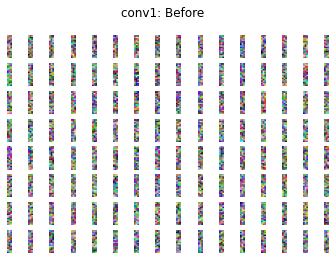

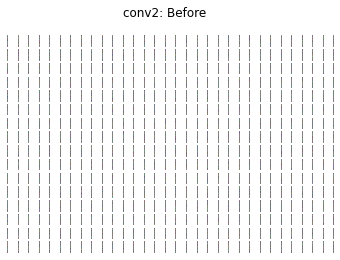

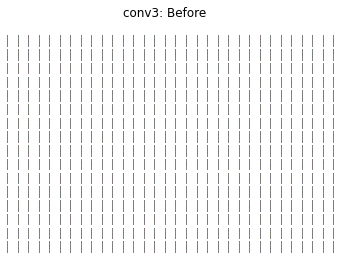

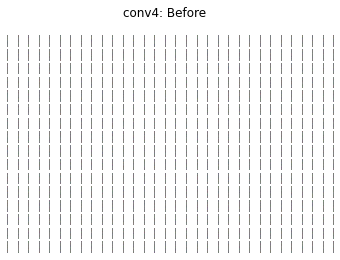

KeyboardInterrupt: 

In [11]:
dirname = get_next_logdir()
MODEL_WEIGHTS_IMAGEPATH = os.path.join(dirname,"weights")

vis_layers = {
    "conv1" : model.conv1,
    "conv2" : model.conv2,
    "conv3" : model.conv3,
    "conv4" : model.conv4,
    "conv5" : model.conv5,
}

for n,l in vis_layers.items():
  VisualizeFilter(l, n, out_dir=os.path.join(MODEL_WEIGHTS_IMAGEPATH, "before"),before=True)

In [ ]:
#train_values = train(model)

In [ ]:
#test_predicted, test_labels , test_values = test(model)

In [ ]:
def save_run(train_dict = None, test_dict= None, save_examples = False, visualizerLayerList=None, dir_name=None):
    if visualizerLayerList is None:
	    visualizerLayerList = dict()
    if dir_name is None:
        dir_name = get_next_logdir()
    from torch.utils.tensorboard import SummaryWriter
    import numbers, json

    def save_log(value_dict):
        for key,value in value_dict.items():
            if isinstance(value, numbers.Number):
                writer.add_scalar(key, value, 0)
            else:
                for e, e_value in enumerate(value):
                    writer.add_scalar(key, e_value, e)

    model_path = os.path.join(dir_name, "model.ckpt")
    model_json_path = os.path.join(dir_name, "model_params.json")
    result_path = os.path.join(dir_name, "results.json")
    model_weights_after_path = os.path.join( MODEL_WEIGHTS_IMAGEPATH,"after")

    model_classcode_path = os.path.join(dir_name, "model_class_code.txt")
    example_images_path = os.path.join(dir_name, "example")
    writer = SummaryWriter(log_dir=dir_name)
    model_dict = { "params": {"num_classes": num_classes, "num_epochs": num_epochs, "batch_size": batch_size, "learning_rate": learning_rate, "learning_rate_decay": learning_rate_decay, "criterion": str(criterion.__class__), "optimizer": str(optimizer.__class__)}, "transformations": [str(t) for t in data_aug_transform],"fine_tune" : fine_tune}


    print("Saving {} in {}".format("model", model_path), end=" ")
    torch.save(model.state_dict(), model_path)
    print("DONE")


    print("Saving {} in {}".format("Logs (if any)", dir_name), end=" ")
    if train_dict is not None: save_log(train_dict)
    if test_dict is not None:save_log(test_dict)
    writer.close()
    print("DONE")

    print("Saving {} in {}".format("parameters", model_json_path), end=" ")
    with open(model_json_path, "w") as jf:
        json.dump(model_dict, jf)
    print("DONE")

    print("Saving {} in {}".format("results", result_path), end=" ")
    result_json = dict()
    for k,v in train_dict.items():
        if any(sub in k for sub in ["F1", "Accuracy", "Loss"]): result_json[k] = v
    for k,v in test_dict.items():
        if any(sub in k for sub in ["F1", "Accuracy", "Loss"]): result_json[k] = v
    with open(result_path, "w") as jf:
        json.dump(result_json, jf)
    print("DONE")

    print("Saving {} in {}".format("class code", model_classcode_path), end=" ")
    with open(model_classcode_path, "w") as f:
        f.write(get_model_code())
    print("DONE")

    if save_examples:
        EXAMPLE_DIR = "./data/examples/"
        if not os.path.exists(EXAMPLE_DIR):
            print("{} path does not exist. Be sure insert in the path the images that you want to try. Follow the istruction in the README.md file".format(EXAMPLE_DIR))
        else:
            print("Saving {} in {}".format("Example Images", example_images_path), end=" ")
            if not os.path.exists(example_images_path): os.makedirs(example_images_path)

            example_dataset = YogaPoseDataset(EXAMPLE_DIR,train=True, transform=norm_transform)
            example_dataset1 = example_dataset[0:1]
            example_dataset2 = example_dataset[1:2]
            example_dataset3 = example_dataset[2:3]

            TransPoseVisualizer(example_dataset1, example_images_path, 1)
            TransPoseVisualizer(example_dataset2, example_images_path, 2)
            TransPoseVisualizer(example_dataset3, example_images_path, 3)
            print("DONE")

    if len(visualizerLayerList) > 0:
        print("Printing {}".format("layer weights"), end=" ")
        for n,l in visualizerLayerList.items():
            VisualizeFilter(l,n, out_dir=model_weights_after_path, before=False)
        print("DONE")


Saving model in ./out/logs/15_Dec[18-09-57]/model.ckpt DONE
Saving Logs (if any) in ./out/logs/15_Dec[18-09-57] DONE
Saving parameters in ./out/logs/15_Dec[18-09-57]/model_params.json DONE
Saving results in ./out/logs/15_Dec[18-09-57]/results.json DONE
Saving class code in ./out/logs/15_Dec[18-09-57]/model_class_code.txt DONE
Printing layer weights 

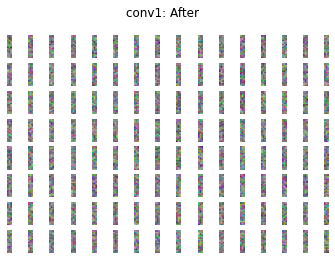

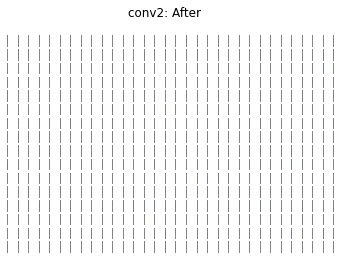

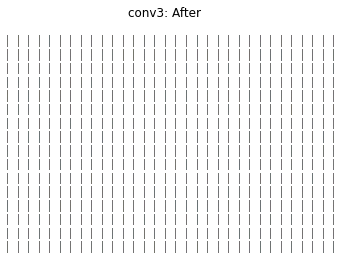

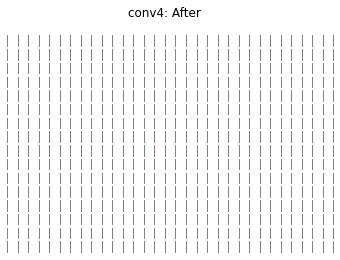

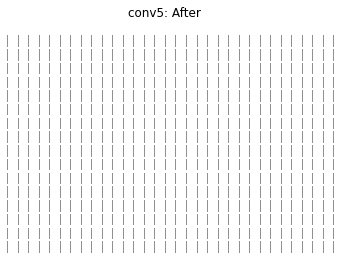

DONE


In [80]:
#save_run(train_values, test_values, visualizerLayerList = vis_layers, dir_name=dirname)